# Inferential Statistics Ib - Frequentism

## Learning objectives

Welcome to the second Frequentist inference mini-project! Over the course of working on this mini-project and the previous frequentist mini-project, you'll learn the fundamental concepts associated with frequentist inference. The following list includes the topics you will become familiar with as you work through these two mini-projects:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

## Prerequisites

For working through this notebook, you are expected to have a very basic understanding of:
* what a random variable is
* what a probability density function (pdf) is
* what the cumulative density function is
* a high-level sense of what the Normal distribution

If these concepts are new to you, please take a few moments to Google these topics in order to get a sense of what they are and how you might use them.

These two notebooks were designed to bridge the gap between having a basic understanding of probability and random variables and being able to apply these concepts in Python. This second frequentist inference mini-project focuses on a real-world application of this type of inference to give you further practice using these concepts. 

In the previous notebook, we used only data from a known normal distribution. You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.

## Hospital medical charges

Imagine that a hospital has hired you as their data analyst. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. This mini-project, as well as the bootstrap and Bayesian inference mini-projects also found in this unit are designed to illustrate how each of the inferential statistics methods have their uses for different use cases. In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?
Answering that last question with a frequentist approach makes some assumptions, or requires some knowledge, about the two groups. In the next mini-project, you'll use bootstrapping to test that assumption. And in the final mini-project of the unit, you're going to create a model for simulating _individual_ charges (not a sampling distribution) that the hospital can use to model a range of scenarios.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). For the purposes of this exercise, assume the observations are the result of random sampling from our one hospital.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import t
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

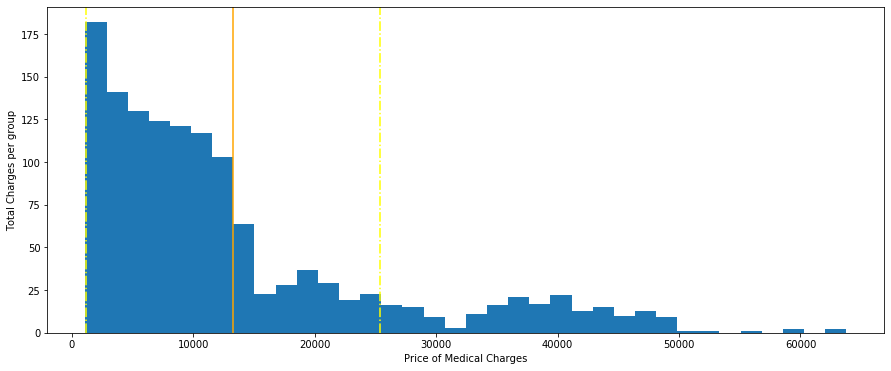

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

mu = np.mean(medical.charges)
sd = np.std(medical.charges)

_ = plt.axvline(mu, c='orange')
_ = plt.axvline(mu + sd, linestyle='-.', color="yellow")
_ = plt.axvline(mu - sd, linestyle='-.', color="yellow")

_ = plt.hist(medical.charges, bins=int(np.sqrt(len(medical.charges))))
_ = plt.xlabel("Price of Medical Charges")
_ = plt.ylabel("Total Charges per group")

In [5]:
mu, sd

(13270.422265141257, 12105.484975561612)

We don't have a normal distribution, therefore the mean and standard deviations aren't as intuitively meaningful as they were in previous exercises

__Q:__ The administrator is concerned that the actual average charge has fallen below 12000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed above, to apply?

__A:__ Resample the data with replacement 1000 times or more, and calculate the mean each sample. Then plot the sampling distribution see where 12,000 falls. Also calculate chance of getting 12,000 or less.

__Q:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A one-sided or two-sided interval? Calculate the critical value and the relevant 95% confidence interval for the mean and comment on whether the administrator should be concerned?

__A:__ One sided, for anything less than 12,000.

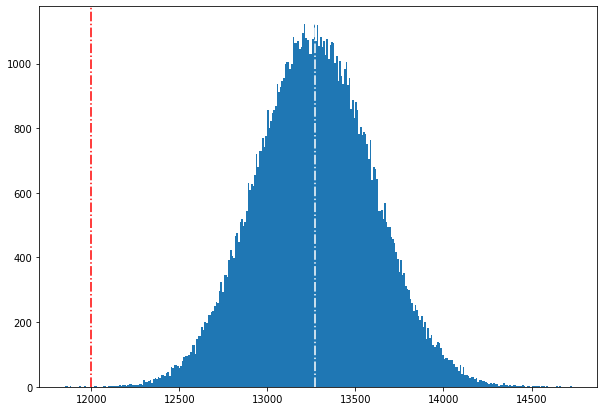

In [30]:
np.random.seed(47)

def bs_reps(data, n=1000, func=np.mean):
    sample = np.empty(n)
    
    for i in range(n):
        sample[i] = func(np.random.choice(data, size=len(data), replace=True))
    
    return sample

bs_means = bs_reps(medical.charges, 100000, np.mean)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
_ = plt.hist(bs_means, bins=int(np.sqrt(len(bs_means))))
_ = plt.axvline(np.mean(bs_means), linestyle="-.", c="white")
_ = plt.axvline(12000, linestyle="-.", c="r")

In [31]:
#6 out of 100,000 means are less than or equal to 12,000
np.sum(bs_means <= 12000)

6

In [32]:
#critical value
t.pdf(.95, len(bs_means)-1)

0.2540577922167937

In [33]:
#99.987% CI
t.interval(alpha=.99988, df=len(bs_means)-1, scale=np.std(bs_means), loc=np.mean(bs_means))

(11995.836332008104, 14543.931290662293)

In [34]:
#The numbers for the intervals don't seem to match?????????????

# 95% CI
print("95% CI: ", np.percentile(bs_means, [2.5,97.5]))

#same as above... 0.012 to 99.987%
np.percentile(bs_means, [100-99.988, 99.988])

95% CI:  [12628.00199572 13925.93120521]


array([12082.35547924, 14492.01395252])

In [35]:
scipy.stats.percentileofscore(bs_means, 12000)

0.006

In [36]:
#Never tell me the odds
100-99.988

0.012000000000000455

__A:__ There's roughly a .01% chance that the average bill is $12,000.

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means where the pooled standard deviation of the two groups is given by
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t* test statistic is then given by

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

What assumption, or assumptions, are we making here?

__A:__ <br>
Ho: People are charged the same whether or not they have insurance.<br>
Ha: People are changed differently depending on whether they have insurance or not.

## I'm not sure about what assumptions we're making
What assumptions are we making? About what? The t-test? Or is it just about the Ho and Ha? Hmmm?

__Q:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

## I'm going to do a bootstrap hypothesis test
(I think that's what it's called)
<br>
We will assume:<br>
Ho: People are charged the same whether or not they have insurance.<br>
Ha: People are changed differently depending on whether they have insurance or not.<br>

Thus we will set the means of both groups to be equal and then compare the differences in mean of our bootstrap samples against our test statistic which is the difference in the mean of the original samples. Given the Ho, we should expect to see a difference as big or greater more than 5% of the time. Oh btw, let's use an alpha of .05.

In [314]:
# Are there nulls?
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
age               1338 non-null int64
sex               1338 non-null int64
bmi               1338 non-null float64
children          1338 non-null int64
smoker            1338 non-null int64
region            1338 non-null int64
charges           1338 non-null float64
insuranceclaim    1338 non-null int64
dtypes: float64(2), int64(6)
memory usage: 83.7 KB


In [37]:
# make groups from the insured and uninsured
ins = medical[medical.insuranceclaim == 1].charges
uni = medical[medical.insuranceclaim == 0].charges

In [38]:
# calculate the mean and sd of the new groups
mui = np.mean(ins)
muu = np.mean(uni)
sdi = np.std(ins)
sdu = np.std(uni)

In [39]:
# compare mean (of the charges) for the entire dataset, the insured mean, and uninsured mean
mu, mui, muu

(13270.422265141257, 16423.928276537677, 8821.421892306305)

In [40]:
# difference in means of amount charged for insured vs uninsured
# insured people are charged $7600 more than uninsured people on average
diff = mui - muu
diff

7602.506384231372

In [41]:
# shift the means of the insured/uninsured groups to be equal
# this agrees with the Ho: people are charged the same regardless of insurance coverage
insured_shifted = ins - mui + mu #insured group - the mean of the insured group + the mean of the combined groups
uninsured_shifted = uni - muu + mu

np.mean(insured_shifted), np.mean(uninsured_shifted) # means are now the same

(13270.422265141255, 13270.422265141257)

In [42]:
#seed set for reproducability
np.random.seed(47)

# Compute 100,000 bootstrap replicates from shifted arrays
bs_replicates_i = bs_reps(insured_shifted, func=np.mean, n=100000)
bs_replicates_u = bs_reps(uninsured_shifted, func=np.mean, n=100000)

# Get replicates of difference of means: bs_replicates
bs_replicates = np.abs(bs_replicates_i - bs_replicates_u) #this isn't the most extreme values, it's just whatever lines up with the other group... right?

# Compute and print p-value: p
p = np.sum(bs_replicates >= diff) / len(bs_replicates)
print('p-value =', p)
print("Max diff:",np.max(bs_replicates))

p-value = 0.0
Max diff: 2600.213683140353


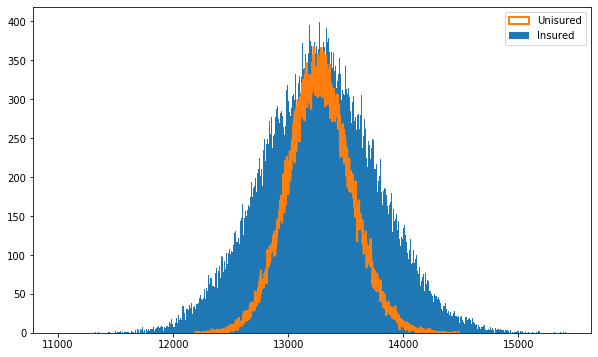

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

_ = plt.hist(bs_replicates_i, bins=1000)
_ = plt.hist(bs_replicates_u, histtype="step", linewidth=2, bins=1000)
_ = plt.legend(["Unisured","Insured"]) ##why's this legend backwards???????????????????
#I only noticed it was backwards after looking at the values for the mins and maxes of the groups below

In [44]:
np.min(bs_replicates_i), np.max(bs_replicates_i), np.min(bs_replicates_u), np.max(bs_replicates_u)

(11004.106282649554,
 15411.321109354536,
 12192.793626979093,
 14479.988304060178)

In [45]:
np.max(bs_replicates_i) - np.min(bs_replicates_u)

3218.5274823754426

Thinking about what's happening... <br>
If the two groups have equal means, when we plot both distributions on one plot, we should expect a difference in the means to be greater than our test statistic, given the null hypothesis is true (both groups are being charged the same). Our test statistic is the difference in means of amount charged for insured vs uninsured (more than \\$7600). Given our 100,000 samples, we did not generate a single replicate with a difference of more than \\$2601. <br>

Given this line of code... <br>
bs_replicates = np.abs(bs_replicates_i - bs_replicates_u) <br>
We find the difference between the two groups of sample means. However, I just realized this is a piecewise comparison, and we are not comparing the extreme highs of on group to the extreme lows of another group, like I did here: np.max(bs_replicates_i) - np.min(bs_replicates_u) = 3218.53
<br><br>
I'm guessing this is the standard way of hypothesis testing in this way, considering this code is basically straight from Datacamp.
<br>
Thoughts?
<br><br>
Anyway, I'm confident we can reject the Null Hypothesis that both groups are being charged the same. Meaning that uninsured people are being charged less.

## Trying the suggested approach with the equations, but it doesn't seem to be working
is n the length?
is s the stdv of the sample? Is x-bar the mean of the sample?


\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

In [46]:
# create variables for better readability below
n0 = len(ins)
s0 = np.std(ins)
x0 = np.mean(ins)

n1 = len(uni)
s1 = np.std(uni)
x1 = np.mean(uni)

# trying to plug numbers into the given formulae
sp = np.sqrt(   ( (n0-1)*s0**2  +  (n1-1)*s1**2 ) / (n0+n1-2)  )
t = (x0-x1) / (np.sqrt(1/n0 + 1/n1))

sp, t # it didn't seem to work... These don't look like correct values to me?

(11512.282899205748, 137011.21240449132)

In [47]:
scipy.stats.ttest_ind(ins, uni) #at least the p value is still really small

Ttest_indResult(statistic=11.893299030876712, pvalue=4.461230231620717e-31)

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and that is much easier to use. All you need to do is pass it your data.

__Q:__ In the above calculations, we assumed the sample variances were equal. We may well suspect they are not (we'll explore this in another assignment). The calculation becomes a little more complicated to do by hand in this case, but we now know of a helpful function. Check the documentation for the function to tell it not to assume equal variances and perform the test again.

__A:__

In [48]:
scipy.stats.ttest_ind(ins, uni, equal_var=False)

Ttest_indResult(statistic=13.298031957975649, pvalue=1.1105103216309125e-37)

__Q:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ From what I understand a z-score applies to each element in a Series, so it will return an array of values, not one value (similar to a t statistic).

## Learning outcomes

Having completed this project notebook, you have good hands-on experience of
* how you can use the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* how to then perform inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test